In [287]:
import pandas as pd
import os
import rasterio
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [165]:
# Ruta al archivo CSV
archivo_csv = r'C:\Users\1\Desktop\datos_grafica\Coordenadas_Grosseto.csv'

# Cargar el archivo CSV en un DataFrame de pandas con i parametri delimitatori corretti
coord_df = pd.read_csv(archivo_csv, delimiter=';', decimal=',')
coord_df.rename(columns={'longitudine': 'lon', 'latitudine': 'lat'}, inplace=True)

# Mostrar el DataFrame
print(coord_df)

   Coordenadas puntos        lon        lat
0     Black plastic 1  11.067751  42.860612
1              Corn 1  11.067724  42.850206
2    Clover station 1  11.065604  42.854430
3     Clover (high) 1  11.076013  42.830474
4      Clover pivot 1  11.070988  42.847443
5             Water 1  11.071573  42.851261
6     Black plastic 2  11.067660  42.860737
7              Corn 2  11.067744  42.850149
8    Clover station 2  11.065461  42.854781
9     Clover (high) 2  11.076012  42.830474
10     Clover pivot 2  11.071106  42.847634
11            Water 2  11.071010  42.851510
12    Black plastic 3  11.067728  42.860673
13             Corn 3  11.067704  42.850273
14   Clover station 3  11.065391  42.855859
15    Clover (high) 3  11.076013  42.830470
16     Clover pivot 3  11.071154  42.847523
17            Water 3  11.071120  42.851660


In [243]:
# Percorso alla cartella delle immagini
cartella_imagenes = r'C:\Users\1\Desktop\datos_grafica\Imagenes_LST_grosseto_gday'

# Ottenere una lista di tutti i nomi dei file nella cartella
nomi_immagini = os.listdir(cartella_imagenes)

# Creare un elenco di dizionari per immagini e punti delle coordinate
righe_da_aggiungere = []

# Iterare su ogni immagine
for nome_immagine in nomi_immagini:
    # Estrarre l'ora dal nome dell'immagine
    ora_str = nome_immagine.split('_')[1].replace('.tif', '')
    # Convertire l'ora in un formato desiderato
    ora = pd.to_datetime(ora_str, format='%H%M%S').strftime('%H:%M:%S')

    # Aprire l'immagine raster
    percorso_immagine = os.path.join(cartella_imagenes, nome_immagine)
    with rasterio.open(percorso_immagine, crs='EPSG:4326') as src:
        # Iterare su ogni punto nel file CSV
        for index, row in coord_df.iterrows():
            # Ottenere le coordinate del punto
            lon, lat = row['lon'], row['lat']
            
            # Convertire le coordinate in coordinate di pixel
            x, y = src.index(lon, lat)

            # Leggere il valore LST dal raster senza verificare i confini
            valore_lst = src.read(1, window=((x, x+1),(y, y+1)))

            # Verificare se valore_lst è vuoto
            if valore_lst.size > 0:
                # Ottenere il tipo di superficie dal file CSV
                tipo_superficie = row['Coordenadas puntos']

                # Aggiungere la riga all'elenco di dizionari
                riga_da_aggiungere = {'Field Type': tipo_superficie, 'Time (UTC)': ora, 'T (K)': valore_lst[0]}
                righe_da_aggiungere.append(riga_da_aggiungere)
            else:
                # Aggiungi la riga con valore NaN
                tipo_superficie = row['Coordenadas puntos']
                riga_da_aggiungere = {'Field Type': tipo_superficie, 'Time (UTC)': ora, 'T (K)': np.nan}
                righe_da_aggiungere.append(riga_da_aggiungere)

# Creare il DataFrame
df_img = pd.DataFrame(righe_da_aggiungere)

# Mostrare il DataFrame risultante
print(df_img)

# Creare un nuovo DataFrame con solo le colonne corrette
df_img_corretto = df_img[['Field Type', 'Time (UTC)', 'T (K)']]

# Creare un nuovo DataFrame con solo le righe corrette
df_corretto = pd.DataFrame(columns=['Field Type', 'Time (UTC)', 'T (K)'])

# Creare un set per tenere traccia dei punti già considerati per ogni immagine
punti_già_aggiunti_per_immagine = set()

# Filtrare le righe corrette
for index, row in df_img_corretto.iterrows():
    # Verificare se i valori di LST sono diversi da -3.4e+38 e non sono NaN
    if not np.allclose(row['T (K)'], -3.4e+38) and not pd.isna(row['T (K)']):
        # Creare una chiave univoca per identificare l'immagine e il punto
        chiave = (row['Field Type'], row['Time (UTC)'])

        # Verificare se il punto è già stato considerato per questa immagine
        if chiave not in punti_già_aggiunti_per_immagine:
            # Aggiungere la riga al DataFrame corretto
            df_corretto = pd.concat([df_corretto, pd.DataFrame([row])], ignore_index=True)

            # Aggiungere il punto al set dei punti già considerati per questa immagine
            punti_già_aggiunti_per_immagine.add(chiave)

# Mostrare il DataFrame risultante corretto
print(df_corretto)

# # Percorso completo per il salvataggio del file CSV
# percorso_salvataggio = r'C:\Users\1\Desktop\datos_grafica\Tabla_imagenes_LST_ok.csv'

# # Salvare il DataFrame come file CSV
# df_corretto.to_csv(percorso_salvataggio, index=False)

# print(f"Il file CSV è stato salvato con successo in: {percorso_salvataggio}")



            Field Type Time (UTC) T (K)
0      Black plastic 1   07:48:15   NaN
1               Corn 1   07:48:15   NaN
2     Clover station 1   07:48:15   NaN
3      Clover (high) 1   07:48:15   NaN
4       Clover pivot 1   07:48:15   NaN
...                ...        ...   ...
1075            Corn 3   14:28:17   NaN
1076  Clover station 3   14:28:17   NaN
1077   Clover (high) 3   14:28:17   NaN
1078    Clover pivot 3   14:28:17   NaN
1079           Water 3   14:28:17   NaN

[1080 rows x 3 columns]
           Field Type Time (UTC)        T (K)
0     Black plastic 1   08:05:48  [313.51996]
1              Corn 1   08:05:48  [310.69073]
2    Clover station 1   08:05:48   [325.3934]
3     Clover (high) 1   08:05:48  [314.22513]
4      Clover pivot 1   08:05:48  [315.23492]
..                ...        ...          ...
622            Corn 3   14:15:52  [323.44733]
623  Clover station 3   14:15:52    [331.646]
624   Clover (high) 3   14:15:52  [312.77972]
625    Clover pivot 3   14:15:52  [

In [244]:
#Open the excel file with in situ data
df_apogee = pd.read_excel(r'C:\Users\1\Desktop\datos_grafica\datos_apogee_cimel.xlsx', sheet_name='APOGEE')
# print(df_apogee)

df_apogee_fix = pd.read_excel(r'C:\Users\1\Desktop\datos_grafica\datos_apogee_cimel.xlsx', sheet_name='APOGEE_fix')
# print(df_apogee_fix)

df_cimel = pd.read_excel(r'C:\Users\1\Desktop\datos_grafica\datos_apogee_cimel.xlsx', sheet_name='CIMEL')
# print(df_cimel)

# Aggiungi la data a tutte le righe nella colonna "Time (UTC)" di df_apogee
df_apogee['Time (UTC)'] = df_apogee['Time (UTC)'].apply(lambda x: datetime.combine(datetime(2023, 6, 26), x))

# Aggiungi la data a tutte le righe nella colonna "Time (UTC)" di df_cimel
df_cimel['Time (UTC)'] = df_cimel['Time (UTC)'].apply(lambda x: datetime.combine(datetime(2023, 6, 26), x))

# Mostra il DataFrame risultante
# print(df_apogee)
# print(df_cimel)


In [245]:
# Compare the data - Apogee and LST images

# Assicurati che le colonne abbiano lo stesso tipo di dato
df_corretto['Time (UTC)'] = pd.to_datetime(df_corretto['Time (UTC)'])
df_corretto['Time (UTC)'] = datetime(2023, 6, 26) + df_corretto['Time (UTC)'].apply(lambda x: timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))
df_apogee['Time (UTC)'] = pd.to_datetime(df_apogee['Time (UTC)'], errors='coerce')

# 2. Creare una funzione per mappare i tipi di superficie
def mappa_tipi_superficie(tipo_superficie):
    if 'water' in tipo_superficie.lower():
        return 'Water'
    elif 'corn' in tipo_superficie.lower():
        return 'Corn'
    elif 'clover (high)' in tipo_superficie.lower():
        return 'Clover (high)'
    elif 'black plastic' in tipo_superficie.lower():
        return 'Black Plastic'
    elif 'clover station' in tipo_superficie.lower():
        return 'Clover Station'
    # Aggiungi altri casi secondo necessità
    else:
        return tipo_superficie

# Creare una colonna nel DataFrame df_corretto con i tipi di superficie mappati
df_corretto['Field Type'] = df_corretto['Field Type'].apply(mappa_tipi_superficie)

# Ordina il DataFrame per tipo di superficie e poi per l'orario
df_corretto = df_corretto.sort_values(by=['Field Type', 'Time (UTC)'])
# Rimuovi le parentesi quadre e cambia i punti in virgole nella colonna "T (K)"
df_corretto['T (K)'] = df_corretto['T (K)'].astype(str).str.replace('\[|\]', '').str.replace('.', ',')
# Converti la colonna "T (K)" in tipo numerico
#df_corretto['T (K)'] = pd.to_numeric(df_corretto['T (K)'], errors='coerce')

# Mostra il DataFrame risultante
print(df_corretto)

percorso = r'C:\Users\1\Desktop\datos_grafica\Tabla_LST_img.xlsx'

# Salva il DataFrame come file Excel
#df_corretto.to_excel(percorso, index=False)



        Field Type          Time (UTC)      T (K)
0    Black Plastic 2023-06-26 08:05:48  313,51996
6    Black Plastic 2023-06-26 08:05:48  314,40442
12   Black Plastic 2023-06-26 08:05:48  309,71817
39   Black Plastic 2023-06-26 08:27:15  319,52155
44   Black Plastic 2023-06-26 08:27:15  328,64496
..             ...                 ...        ...
602          Water 2023-06-26 14:07:45   306,8679
608          Water 2023-06-26 14:07:45    307,177
614          Water 2023-06-26 14:15:52    321,358
620          Water 2023-06-26 14:15:52  312,53506
626          Water 2023-06-26 14:15:52   313,1558

[627 rows x 3 columns]


C:\conda_tmp\ipykernel_9944\2919384898.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  df_corretto['T (K)'] = df_corretto['T (K)'].astype(str).str.replace('\[|\]', '').str.replace('.', ',')
C:\conda_tmp\ipykernel_9944\2919384898.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_corretto['T (K)'] = df_corretto['T (K)'].astype(str).str.replace('\[|\]', '').str.replace('.', ',')


      Field Type          Time (UTC)  T (K)_images  T (K)_apogee
0  Black Plastic 2023-06-26 08:27:15    321.190593    334.610000
1  Black Plastic 2023-06-26 08:47:19    325.546217    334.696667
2  Black Plastic 2023-06-26 09:07:37    328.111240    337.890000
3  Black Plastic 2023-06-26 09:25:05    319.579163    339.336667
4  Black Plastic 2023-06-26 09:34:14    317.044293    340.370000
5          Water 2023-06-26 08:05:48    306.162597    299.776667
6          Water 2023-06-26 08:10:50    306.047973    299.630000


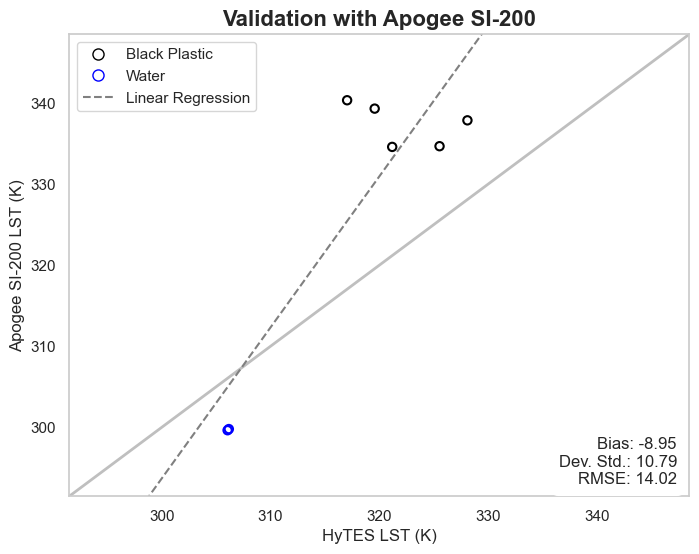

In [291]:
df = pd.read_excel(percorso, sheet_name='Tabla_final')
print(df)

# Mappa dei colori per i tipi di superficie
colore_superficie = {'Black Plastic': 'black', 'Water': 'blue'}

legend_elements = []

margin = 0.2  # Regola questo valore per ottenere lo spazio desiderato
min_value = min(min(df['T (K)_apogee']), min(df['T (K)_images']))
max_value = max(max(df['T (K)_apogee']), max(df['T (K)_images']))
margin_x = (max_value - min_value) * margin
min_value_x = min_value - margin_x
max_value_x = max_value + margin_x

# Crea un grafico a dispersione con colori distinti per tipo di superficie
plt.figure(figsize=(8, 6))
for superficie, colore in colore_superficie.items():
    subset = df[df['Field Type'] == superficie]
    plt.scatter(subset['T (K)_images'], subset['T (K)_apogee'], label=superficie, color='none', edgecolors=colore, marker='o', linewidths=1.5)
    legend_elements.append(Line2D([0], [0], marker='o', color='none', markeredgecolor=colore, linestyle='', markersize=8, label=superficie))
    
# Personalizza il grafico
plt.title('Validation with Apogee SI-200', fontsize=16, fontweight='bold')
plt.ylabel('Apogee SI-200 LST (K)')
plt.xlabel('HyTES LST (K)')
plt.legend(title='Field Type', loc='upper left')  # Impostazione della posizione della legenda

# Imposta gli assi con margine
plt.xlim(min_value_x, max_value_x)
plt.ylim(min_value_x, max_value_x)

plt.plot([min_value_x, max_value_x], [min_value_x, max_value_x], color='gray', linewidth=2, alpha=0.5)

# Rimuovi le griglie di fondo
plt.grid(False)

# Calcola la retta di regressione
x_reg = np.linspace(min_value_x, max_value_x, 100)
coef = np.polyfit(df['T (K)_images'], df['T (K)_apogee'], 1)
y_reg = np.polyval(coef, x_reg)

# Aggiungi la retta di regressione
plt.plot(x_reg, y_reg, color='gray', linestyle='dashed', linewidth=1.5)

# Aggiungi la legenda con la retta di regressione
plt.legend(handles=legend_elements + [Line2D([0], [0], color='gray', linestyle='dashed', linewidth=1.5, label='Linear Regression')], loc='upper left')  

# Calcola le metriche
bias = np.mean(df['T (K)_images'] - df['T (K)_apogee'])
std_dev = np.std(df['T (K)_images'] - df['T (K)_apogee'])
rmse = np.sqrt(np.mean((df['T (K)_images'] - df['T (K)_apogee'])**2))

# Aggiungi le metriche al grafico
plt.text(0.98, 0.02, f'Bias: {bias:.2f}\nDev. Std.: {std_dev:.2f}\nRMSE: {rmse:.2f}', transform=plt.gca().transAxes, ha='right', va='bottom', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

plt.show()

       Field Type          Time (UTC)  T (K)_images  T (K)_apogee_fix
0   Clover (high) 2023-06-26 08:05:48    314.225130        295.906184
1   Clover (high) 2023-06-26 08:10:50    310.229060        296.324586
2   Clover (high) 2023-06-26 08:16:32    313.491333        296.640165
3   Clover (high) 2023-06-26 08:21:49    310.115660        297.115290
4   Clover (high) 2023-06-26 08:32:10    312.492800        298.210670
5   Clover (high) 2023-06-26 08:37:42    311.524253        298.682005
6   Clover (high) 2023-06-26 08:42:21    311.260967        299.046916
7   Clover (high) 2023-06-26 08:52:21    309.602870        299.273610
8   Clover (high) 2023-06-26 08:57:23    310.856870        299.471928
9   Clover (high) 2023-06-26 09:02:25    308.819100        300.020654
10  Clover (high) 2023-06-26 09:07:37    306.987500        300.675188
11  Clover (high) 2023-06-26 09:12:43    305.810300        300.731770
12  Clover (high) 2023-06-26 09:17:27    311.532350        301.297388
13  Clover (high) 20

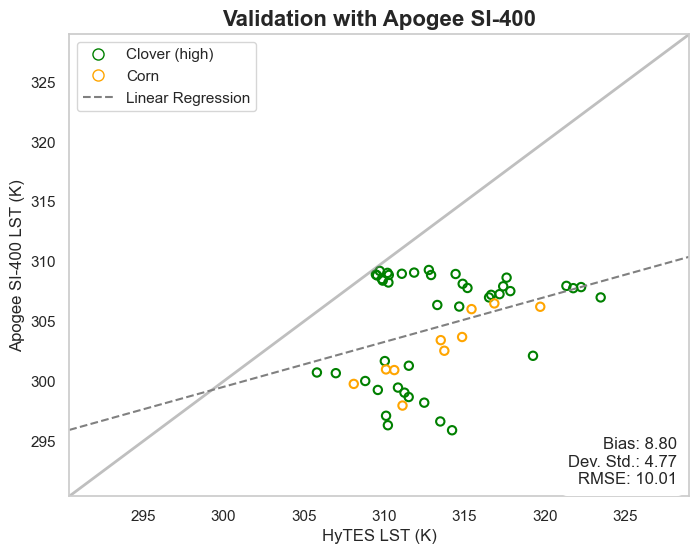

In [295]:
df = pd.read_excel(percorso, sheet_name='apogee_fix')
print(df)

# Mappa dei colori per i tipi di superficie
colore_sup = {'Clover (high)': 'green', 'Corn': 'orange'}

legend_elements = []

margin = 0.2  # Regola questo valore per ottenere lo spazio desiderato
min_value = min(min(df['T (K)_apogee_fix']), min(df['T (K)_images']))
max_value = max(max(df['T (K)_apogee_fix']), max(df['T (K)_images']))
margin_x = (max_value - min_value) * margin
min_value_x = min_value - margin_x
max_value_x = max_value + margin_x

# Crea un grafico a dispersione con colori distinti per tipo di superficie
plt.figure(figsize=(8, 6))
for superficie, colore in colore_sup.items():
    subset = df[df['Field Type'] == superficie]
    plt.scatter(subset['T (K)_images'], subset['T (K)_apogee_fix'], label=superficie, color='none', edgecolors=colore, marker='o', linewidths=1.5)
    legend_elements.append(Line2D([0], [0], marker='o', color='none', markeredgecolor=colore, linestyle='', markersize=8, label=superficie))
    
# Personalizza il grafico
plt.title('Validation with Apogee SI-400', fontsize=16, fontweight='bold')
plt.ylabel('Apogee SI-400 LST (K)')
plt.xlabel('HyTES LST (K)')
plt.legend(title='Field Type', loc='upper left')  # Impostazione della posizione della legenda

# Imposta gli assi con margine
plt.xlim(min_value_x, max_value_x)
plt.ylim(min_value_x, max_value_x)

plt.plot([min_value_x, max_value_x], [min_value_x, max_value_x], color='gray', linewidth=2, alpha=0.5)

# Rimuovi le griglie di fondo
plt.grid(False)

# Calcola la retta di regressione
x_reg = np.linspace(min_value_x, max_value_x, 100)
coef = np.polyfit(df['T (K)_images'], df['T (K)_apogee_fix'], 1)
y_reg = np.polyval(coef, x_reg)

# Aggiungi la retta di regressione
plt.plot(x_reg, y_reg, color='gray', linestyle='dashed', linewidth=1.5)

# Aggiungi la legenda con la retta di regressione
plt.legend(handles=legend_elements + [Line2D([0], [0], color='gray', linestyle='dashed', linewidth=1.5, label='Linear Regression')], loc='upper left')  

# Calcola le metriche
bias = np.mean(df['T (K)_images'] - df['T (K)_apogee_fix'])
std_dev = np.std(df['T (K)_images'] - df['T (K)_apogee_fix'])
rmse = np.sqrt(np.mean((df['T (K)_images'] - df['T (K)_apogee_fix'])**2))

# Aggiungi le metriche al grafico
plt.text(0.98, 0.02, f'Bias: {bias:.2f}\nDev. Std.: {std_dev:.2f}\nRMSE: {rmse:.2f}', transform=plt.gca().transAxes, ha='right', va='bottom', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

plt.show()

      Field Type          Time (UTC)  T (K)_images  T (K)_cimel
0  Black Plastic 2023-06-26 13:48:46    328.082567   343.816667
1  Black Plastic 2023-06-26 13:53:01    338.061817   342.146667
2  Black Plastic 2023-06-26 14:07:45    315.889980   344.616667
3  Black Plastic 2023-06-26 14:15:52    317.872437   343.366667
4           Corn 2023-06-26 11:54:02    315.046167   306.245000
5           Corn 2023-06-26 12:07:35    319.331810   306.566667
6          Water 2023-06-26 09:34:14    313.580163   300.807500


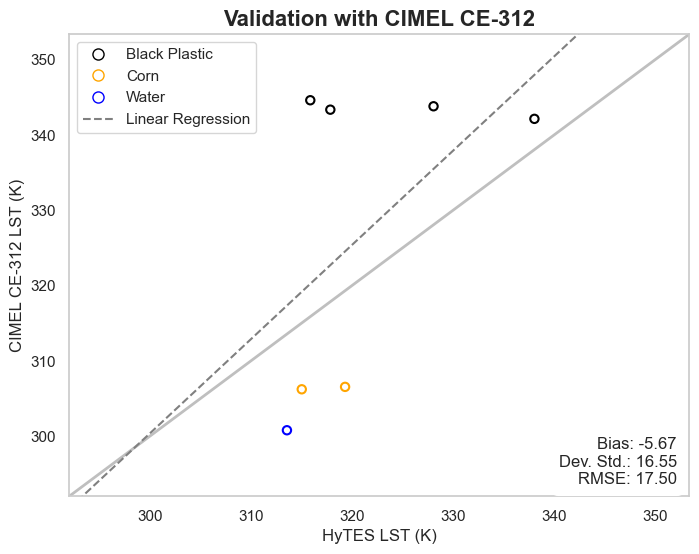

In [298]:
df = pd.read_excel(percorso, sheet_name='Cimel_final')
print(df)

# Mappa dei colori per i tipi di superficie
colore_sup = {'Black Plastic': 'black', 'Corn': 'orange', 'Water': 'blue'}

legend_elements = []

margin = 0.2  # Regola questo valore per ottenere lo spazio desiderato
min_value = min(min(df['T (K)_cimel']), min(df['T (K)_images']))
max_value = max(max(df['T (K)_cimel']), max(df['T (K)_images']))
margin_x = (max_value - min_value) * margin
min_value_x = min_value - margin_x
max_value_x = max_value + margin_x

# Crea un grafico a dispersione con colori distinti per tipo di superficie
plt.figure(figsize=(8, 6))
for superficie, colore in colore_sup.items():
    subset = df[df['Field Type'] == superficie]
    plt.scatter(subset['T (K)_images'], subset['T (K)_cimel'], label=superficie, color='none', edgecolors=colore, marker='o', linewidths=1.5)
    legend_elements.append(Line2D([0], [0], marker='o', color='none', markeredgecolor=colore, linestyle='', markersize=8, label=superficie))
    
# Personalizza il grafico
plt.title('Validation with CIMEL CE-312', fontsize=16, fontweight='bold')
plt.ylabel('CIMEL CE-312 LST (K)')
plt.xlabel('HyTES LST (K)')
plt.legend(title='Field Type', loc='upper left')  # Impostazione della posizione della legenda

# Imposta gli assi con margine
plt.xlim(min_value_x, max_value_x)
plt.ylim(min_value_x, max_value_x)

plt.plot([min_value_x, max_value_x], [min_value_x, max_value_x], color='gray', linewidth=2, alpha=0.5)

# Rimuovi le griglie di fondo
plt.grid(False)

# Calcola la retta di regressione
x_reg = np.linspace(min_value_x, max_value_x, 100)
coef = np.polyfit(df['T (K)_images'], df['T (K)_cimel'], 1)
y_reg = np.polyval(coef, x_reg)

# Aggiungi la retta di regressione
plt.plot(x_reg, y_reg, color='gray', linestyle='dashed', linewidth=1.5)

# Aggiungi la legenda con la retta di regressione
plt.legend(handles=legend_elements + [Line2D([0], [0], color='gray', linestyle='dashed', linewidth=1.5, label='Linear Regression')], loc='upper left')  

# Calcola le metriche
bias = np.mean(df['T (K)_images'] - df['T (K)_cimel'])
std_dev = np.std(df['T (K)_images'] - df['T (K)_cimel'])
rmse = np.sqrt(np.mean((df['T (K)_images'] - df['T (K)_cimel'])**2))

# Aggiungi le metriche al grafico
plt.text(0.98, 0.02, f'Bias: {bias:.2f}\nDev. Std.: {std_dev:.2f}\nRMSE: {rmse:.2f}', transform=plt.gca().transAxes, ha='right', va='bottom', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

plt.show()